In [ ]:
!pip install kaggle
!pip install mne scipy
!pip install pyqt5

import scipy.io
import numpy as np
import matplotlib
import mne
import os
import pathlib
import pandas as pd
import shutil
from pathlib import Path

matplotlib.use('Agg')

from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.5/270.5 kB 16.9 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
import mne
from pathlib import Path

task = 'VEP'

base_path = Path(f'/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/{task}/sub001')
output_folder = Path(f'/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/{task}/sub001')
epoch_per_sub_path = Path(f'/content/drive/My Drive/mindlock-eeg-files/session-1/sum-epochs/{task}/')

epoch_per_sub_path.mkdir(parents=True, exist_ok=True)

for n in range(1, 2):
    nSub = str(n).zfill(3)
    subject = "sub" + nSub
    print("Processing subject:", subject)

    sample_data_dir = base_path / subject
    subject_output_folder = output_folder / subject
    subject_output_folder.mkdir(parents=True, exist_ok=True)

    fif_files = list(sample_data_dir.glob('*.fif'))

    subject_epochs_list = []  # Hold all epochs for this subject

    # Iterate through each .fif file
    for fif_file in fif_files:
        print(f"Processing file: {fif_file.name}")
        raw = mne.io.read_raw_fif(fif_file, preload=True)

        # Set the channel types
        raw.set_channel_types({'Marker': 'stim'})

        # Set the montage
        montage = mne.channels.make_standard_montage('easycap-M1')
        raw.set_montage(montage)

        # Setting events on Marker channel
        events = mne.find_events(raw, stim_channel='Marker')

        # Define event ID
        if task == 'VEP':
            event_id = {'VEP': 3}
        elif task == 'AEP':
            event_id = {'AEP': 4}
        elif task == 'SEP':
            event_id = {'SEP': 5}
        else:
            raise ValueError("Unknown task specified")

        # Create epochs without filtering
        tmin = -0.2
        tmax = 0.8
        baseline = (None, 0)

        epochs = mne.Epochs(raw,
                            events=events,
                            event_id=event_id,
                            tmin=tmin,
                            tmax=tmax,
                            baseline=baseline,
                            preload=True)

        subject_epochs_list.append(epochs)

        # Save individual epoch files
        original_name = fif_file.stem
        unfiltered_file_name = f"{original_name}-epo-unfiltered.fif"
        output_path = subject_output_folder / unfiltered_file_name
        epochs.save(output_path, overwrite=True)

    # Concatenate and save all epochs for the subject
    if subject_epochs_list:
        all_epoch_per_sub = mne.concatenate_epochs(subject_epochs_list)
        subject_epoch_save_path = epoch_per_sub_path / f"{subject}-all-epo.fif"
        all_epoch_per_sub.save(subject_epoch_save_path, overwrite=True)
        print(f"Saved all concatenated epochs for subject {subject} to: {subject_epoch_save_path}")


Processing subject: sub001


In [ ]:
task = 'VEP'

base_path = Path(f'/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/{task}/sub001/sub001-{task}-unfiltered')
output_folder = Path(f'/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/{task}')

for n in range(1, 2):
    nSub = str(n).zfill(3)
    subject = "sub" + nSub
    print("Processing subject: ", subject)

    sample_data_dir = base_path / subject
    subject_output_folder = output_folder / subject
    subject_output_folder.mkdir(parents=True, exist_ok=True)

    fif_files = list(sample_data_dir.glob('*.fif'))

    # Iterate through each .fif file
    for fif_file in fif_files:
        print(f"Processing file: {fif_file.name}")
        raw = mne.io.read_raw_fif(fif_file, preload=True)

        # Set the channel types
        raw.set_channel_types({'Marker': 'stim'})

        # Set the montage
        montage = mne.channels.make_standard_montage('easycap-M1')
        raw.set_montage(montage)

        # Setting events on Marker channel
        events = mne.find_events(raw, stim_channel='Marker')

        # Define event ID
        event_id = {'VEP': 3} if task == 'VEP' else {'AEP': 4, 'SEP': 5}[task]

        # Create epochs and baseline correction
        tmin = -0.2
        tmax = 0.8
        baseline = (None, 0)

        epochs = mne.Epochs(raw,
                            events=events,
                            event_id=event_id,
                            tmin=tmin,
                            tmax=tmax,
                            baseline=baseline,
                            preload=True)


        original_name = fif_file.stem
        filtered_file_name = f"{original_name}-epo-unfiltered.fif"

        output_path = subject_output_folder / filtered_file_name
        epochs.save(output_path, overwrite=True)

Processing subject:  sub001


In [ ]:
import mne
from pathlib import Path

task = 'VEP'

# Path to the folder where sub001's files are directly stored
base_path = Path(f'/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/{task}/sub001/sub001-{task}-unfiltered')
output_path = Path(f'/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/{task}/epochs')

# Ensure base_path exists
if base_path.exists():
    print("Processing subject: sub001")

    # List all .fif files in the base_path
    fif_files = list(base_path.glob('*.fif'))

    # Check if there are any .fif files in the directory
    if not fif_files:
        print("No .fif files found in the directory.")
    else:
        # Print the name of each .fif file
        for fif_file in fif_files:
            print(f"Found file: {fif_file.name}")
else:
    print(f"Directory {base_path} does not exist.")


Processing subject: sub001
Found file: epoch000019.fif
Found file: epoch000027.fif
Found file: epoch000028.fif
Found file: epoch000048.fif
Found file: epoch000050.fif
Found file: epoch000058.fif
Found file: epoch000060.fif
Found file: epoch000067.fif
Found file: epoch000078.fif
Found file: epoch000093.fif
Found file: epoch000097.fif
Found file: epoch000126.fif
Found file: epoch000130.fif
Found file: epoch000140.fif
Found file: epoch000144.fif
Found file: epoch000148.fif
Found file: epoch000153.fif
Found file: epoch000164.fif
Found file: epoch000170.fif
Found file: epoch000188.fif
Found file: epoch000200.fif
Found file: epoch000204.fif
Found file: epoch000214.fif
Found file: epoch000243.fif
Found file: epoch000246.fif
Found file: epoch000258.fif
Found file: epoch000278.fif
Found file: epoch000280.fif
Found file: epoch000290.fif
Found file: epoch000301.fif
Found file: epoch000316.fif
Found file: epoch000326.fif
Found file: epoch000347.fif
Found file: epoch000349.fif
Found file: epoch0003

In [ ]:
import mne
from pathlib import Path

task = 'VEP'

# Paths to the input folder and output folder
base_path = Path(f'/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/{task}/sub001/sub001-{task}-unfiltered')
output_path = Path(f'/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/{task}/epochs')
output_path.mkdir(parents=True, exist_ok=True)  # Ensure output directory exists

# Check if base_path exists
if base_path.exists():
    print("Processing subject: sub001")

    # List all .fif files in the base_path
    fif_files = list(base_path.glob('*.fif'))

    # Check if there are any .fif files in the directory
    if not fif_files:
        print("No .fif files found in the directory.")
    else:
        all_epochs = []  # List to store all epochs for concatenation

        for fif_file in fif_files:
            print(f"Processing file: {fif_file.name}")

            # Load raw data from .fif file
            raw = mne.io.read_raw_fif(fif_file, preload=True)

            # Set the channel types
            raw.set_channel_types({'Marker': 'stim'})

            # Set the montage
            montage = mne.channels.make_standard_montage('easycap-M1')
            raw.set_montage(montage)

            # Find events on the Marker channel
            events = mne.find_events(raw, stim_channel='Marker')

            # Define event ID based on the task type
            event_id = {'VEP': 3} if task == 'VEP' else {'AEP': 4, 'SEP': 5}[task]

            # Create epochs with baseline correction
            tmin = -0.2
            tmax = 0.8
            baseline = (None, 0)
            epochs = mne.Epochs(raw,
                                events=events,
                                event_id=event_id,
                                tmin=tmin,
                                tmax=tmax,
                                baseline=baseline,
                                preload=True)

            # Save each epoch file individually in the output folder
            individual_epoch_path = output_path / f"{fif_file.stem}-epo.fif"
            epochs.save(individual_epoch_path, overwrite=True)

            # Append the created epochs to the list for concatenation
            all_epochs.append(epochs)

        # Concatenate all epochs and save as a single file
        if all_epochs:
            concatenated_epochs = mne.concatenate_epochs(all_epochs)
            concatenated_epochs_path = output_path / "sub001-all-epo.fif"
            concatenated_epochs.save(concatenated_epochs_path, overwrite=True)
            print(f"Saved concatenated epochs to: {concatenated_epochs_path}")

else:
    print(f"Directory {base_path} does not exist.")


Processing subject: sub001
Processing file: epoch000019.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000019.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000019.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000027.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000027.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000027.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000028.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000028.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000028.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000048.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000048.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000048.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000050.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000050.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000050.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000058.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000058.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000058.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000060.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000060.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000060.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000067.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000067.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000067.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000078.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000078.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000078.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000093.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000093.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000093.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000097.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000097.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000097.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000126.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000126.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000126.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000130.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000130.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000130.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000140.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000140.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000140.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000144.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000144.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000144.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000148.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000148.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000148.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000153.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000153.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000153.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000164.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000164.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000164.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000170.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000170.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000170.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000188.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000188.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000188.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000200.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000200.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000200.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000204.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000204.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000204.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000214.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000214.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000214.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000243.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000243.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000243.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000246.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000246.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000246.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000258.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000258.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000258.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000278.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000278.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000278.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000280.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000280.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000280.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000290.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000290.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000290.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000301.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000301.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000301.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000316.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000316.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000316.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000326.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000326.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000326.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000347.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000347.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000347.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000349.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000349.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000349.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000369.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000369.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000369.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000385.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000385.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000385.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000391.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000391.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000391.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000393.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000393.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000393.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000395.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000395.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000395.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000399.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000399.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000399.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000407.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000407.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000407.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000427.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000427.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000427.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000434.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000434.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000434.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000441.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000441.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000441.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000449.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000449.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000449.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000466.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000466.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000466.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000467.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000467.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000467.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000469.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000469.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000469.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000477.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000477.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000477.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000524.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000524.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000524.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000525.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000525.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000525.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000539.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000539.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000539.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000556.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000556.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000556.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000561.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000561.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000561.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000574.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000574.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000574.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000580.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000580.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000580.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000586.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000586.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000586.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000589.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000589.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000589.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000592.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000592.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000592.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Processing file: epoch000599.fif
Opening raw data file /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000599.fif...


<ipython-input-13-b122fe3b5345>:28: RuntimeWarning: This filename (/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/sub001/sub001-VEP-unfiltered/epoch000599.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
1 event found on stim channel Marker
Event IDs: [3]
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)
Saved concatenated epochs to: /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/epochs/sub001-all-epo.fif


In [ ]:
epochs_path= Path('/content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/epochs/sub001-all-epo.fif')
epochs = mne.read_epochs(epochs_path, preload=False)

Reading /content/drive/My Drive/mindlock-eeg-files/session-1/preprocessed-sub/VEP/epochs/sub001-all-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated


In [ ]:
epochs.info

<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 64 EEG, 1 Stimulus
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 65
 projs: []
 sfreq: 250.0 Hz
>

In [ ]:
epochs_data = epochs.get_data()

# Check the shape of the data
print(epochs_data.shape)

Loading data for 60 events and 251 original time points ...
(60, 65, 251)


Loading data for 60 events and 251 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


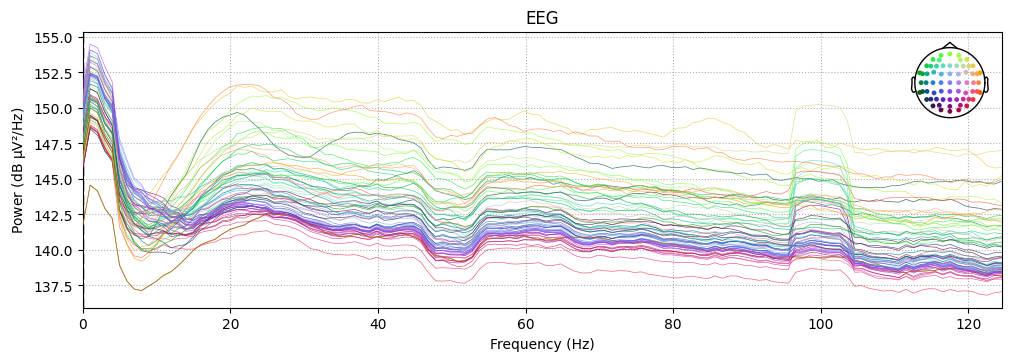

In [ ]:
epochs.compute_psd().plot(picks="eeg", exclude="bads", amplitude=False)

In [ ]:
epochs_path2= Path('/content/drive/My Drive/mindlock-eeg-files/session-1/sum-epochs/VEP/sub001-all-epo.fif')
epochs2 = mne.read_epochs(epochs_path2, preload=False)

Reading /content/drive/My Drive/mindlock-eeg-files/session-1/sum-epochs/VEP/sub001-all-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated


Loading data for 60 events and 251 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


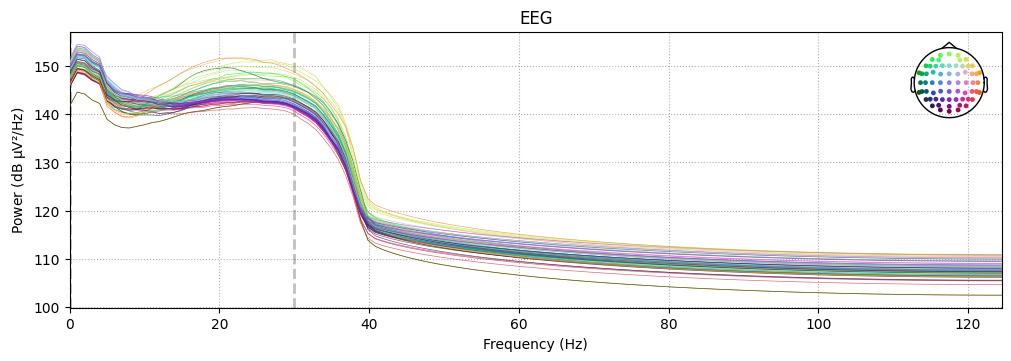

In [ ]:
epochs2.compute_psd().plot(picks="eeg", exclude="bads", amplitude=False)